<h1>Pre-processing and Modeling</h1>

Topic modeling is an unsupervised machine learning technique used to detect words and phrases within documents                                                                                                                                                    and automatically cluster groups of words and similar expressions that best characterize a set of documents.

This NLP technique is useful for tasks including text classification, extracting themes from documents, and building a recommender systems to recommend other text such as an article.

The topic modeling technique that will be used is LDA, Latent Dirichlet Analysis. This model assigns each word to a random topic. Then iteratively, the algorithm then reassigns the word to a new topic and considers a few things. First, what is the probability of the word belonging to a topic and the probability of the document to be generated by a topic.

<h3>Import Packages</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import word_tokenize
#from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

<h3>Load Data</h3>

In [2]:
from sqlalchemy import create_engine, MetaData, Table, select, func, distinct

engine = create_engine("sqlite:///joblist.sqlite")
metadata = MetaData()
data = Table('data', metadata, autoload=True, autoload_with=engine)
stmt = select([data.columns.jobdescription.distinct(), data.columns.label])
connection = engine.connect()
results = connection.execute(stmt).fetchall()

df_data = pd.DataFrame(results)
df_data.columns = results[0].keys()
df_data['jobdescription'] = df_data['jobdescription'].astype('string')

In [3]:
df_data.head()

,jobdescription,label
0,Position Title:Pricing Analyst Position Type: ...,0
1,Title: Senior Data Analyst - Telephony Manager...,0
2,We are looking for a talented Fuel Cell Data E...,0
3,CAREER OPPORTUNITY SENIOR METER DATA ANALYST L...,0
4,The Data Engineer reports directly to the Dire...,0


In [4]:
df_data.describe(include='all')

,jobdescription,label
count,629,629.000000
unique,628,NaN
top,Beta-Calco is seeking a dynamic Business Intel...,NaN
freq,2,NaN
mean,NaN,0.389507
std,NaN,0.488027
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


According to this, we actually have 72 duplicate job descriptions.

<h2>Count Vectorizer + Topic Modeling</h2>

The topic modeling technique LDA uses the text pre-processed via CountVectorizer function as an input. CountVectorizer returns an encoded vector with an integer count for each word.

Here, we will tokenize, use the built-in stop words list, and keep only tokens that appear in at least 4 dfs (document frequencies).

In [5]:
from nltk.corpus import stopwords

combined_stopwords = ENGLISH_STOP_WORDS.union(stopwords.words('french'))

cv = CountVectorizer(analyzer='word',  
                     stop_words = combined_stopwords,
                     lowercase = True, 
                     min_df=4,
                     max_df = 0.99,
                     ngram_range=(1,2))
count_vector = cv.fit_transform(df_data['jobdescription'])

In [6]:
%%time
# Initialize LDA model with 10 topics
lda_model = LatentDirichletAllocation(n_components=10,
                                      random_state=42)

# Fit it to our CountVectorizer Transformation
X_topics = lda_model.fit_transform(count_vector)

# Define variables
n_top_words = 10
topic_summaries = []

# Get the topic words
topic_word = lda_model.components_

# Get the vocabulary from the text features
vocab = cv.get_feature_names()

# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: business | experience | data | ibm | work | technology | waste | management | information | cloud
Topic 1: data | team | experience | canada | business | bell | ca | ability | skills | development
Topic 2: learning | machine | machine learning | data | experience | work | models | software | ml | science
Topic 3: shopping | 00 | preferred | experience | years | data | contract | years required | required | pinterest
Topic 4: data | business | experience | work | team | management | analysis | analytics | solutions | tools
Topic 5: data | business | experience | analytics | bmo | help | depth | skills | stakeholders | solutions
Topic 6: data | business | experience | skills | work | analysis | sales | reporting | team | analyst
Topic 7: wattpad | data | work | business | analytics | experience | stories | world | sun | sun life
Topic 8: data | business | experience | work | management | skills | team | support | requirements | ability
Topic 9: data | experience | business | tea

import eli5



<h3>Create Train and Test Data Sets</h3>

In [7]:
train_data, test_data = train_test_split(df_data,
                               test_size=0.20, 
                               random_state=123)

In [8]:
y_train = train_data['label'].values
y_test = test_data['label'].values

In [9]:
y_train.shape

(503,)

In [10]:
y_test.shape

(126,)

Use TF-IDF to extract features before fitting the classifer.

In [11]:
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Initialize TFIDF Vectorizer
tvec = TfidfVectorizer(analyzer = 'word',  
                       stop_words = ENGLISH_STOP_WORDS.union(stopwords.words('french')), 
                       lowercase= True, 
                       min_df=4, 
                       #max_df = 0.95,
                       ngram_range = (1,2))

In [12]:
# Fit text data
tvec.fit_transform(train_data['jobdescription'].values)

<503x11473 sparse matrix of type '<class 'numpy.float64'>'
	with 181990 stored elements in Compressed Sparse Row format>

In [13]:
# Extract features from x_train and x_test using TF-IDF
x_train_tfidf = tvec.transform(train_data['jobdescription'].values)
x_test_tfidf = tvec.transform(test_data['jobdescription'].values)

In [14]:
x_test_tfidf

<126x11473 sparse matrix of type '<class 'numpy.float64'>'
	with 43280 stored elements in Compressed Sparse Row format>

In [15]:
x_train_tfidf

<503x11473 sparse matrix of type '<class 'numpy.float64'>'
	with 181990 stored elements in Compressed Sparse Row format>

<h2>Analyzing Job Descriptions: Baseline Model with Log Reg</h2>

In [16]:
# Init log reg model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

In [17]:
model = logreg.fit(x_train_tfidf, y_train)

<h3>Cross-Validation</h3>

In [18]:
# Apply 10-fold cross-validation
clf_result = cross_val_score(model, x_train_tfidf, y_train, cv=10, scoring='accuracy')
print("The mean of cross validation is: ", clf_result.mean())

The mean of cross validation is:  0.8529019607843138


<h3>Evaluation Metrics of Test data</h3>

In [19]:
# Predict y values using x test values
y_pred = model.predict(x_test_tfidf)
precision, recall, fscore, support = score(y_test, 
                                            y_pred, 
                                            pos_label=1, 
                                            average ='binary')

print("Classification Report: \nPrecision: {}, \nRecall: {}, \nF-score: {}, \nAccuracy: {}".format(round(precision,3),round(recall,3),round(fscore,3),round((y_pred==y_test).sum()/len(y_test),3)))

Classification Report: 
Precision: 0.897, 
Recall: 0.7, 
F-score: 0.787, 
Accuracy: 0.849


In [20]:
# Confusion matrix
#confusion_matrix(y_test, y_pred)

array([[72,  4],
       [15, 35]])

Text(0.5, 15.0, 'Predicted Label')

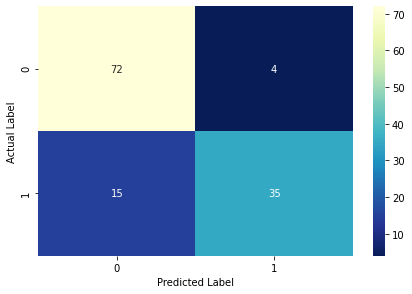

In [40]:
import seaborn as sns

# Plot confusion matrix

class_labels = [0, 1]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Create heatmap
conf_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf_df, annot=True, cmap="YlGnBu_r", fmt='g')
#ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")

In [21]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88        76
           1       0.90      0.70      0.79        50

    accuracy                           0.85       126
   macro avg       0.86      0.82      0.83       126
weighted avg       0.86      0.85      0.84       126



<h3>Create a DF to hold Prediction Outcomes</h3>

In [22]:
job_df = pd.DataFrame(y_test, columns=['Actual'])
job_df['Prediction for 1'] = y_pred
job_df['Prediction Probability for 0 (Analyst)'] = model.predict_proba(x_test_tfidf)[:,0]
job_df['Prediction Probability for 1 (Scientist)'] = model.predict_proba(x_test_tfidf)[:,1]
#job_df.head()

In [23]:
job_df.head(10)

,Actual,Prediction for 1,Prediction Probability for 0 (Analyst),Prediction Probability for 1 (Scientist)
0,1,1,0.242301,0.757699
1,1,0,0.602770,0.397230
2,1,1,0.438233,0.561767
3,1,1,0.413974,0.586026
4,0,0,0.828804,0.171196
5,1,1,0.255938,0.744062
6,0,0,0.823035,0.176965
7,0,0,0.799336,0.200664
8,0,0,0.813486,0.186514
9,1,0,0.699179,0.300821


<h3>ROC Curve</h3>

Receiver Operating Characteristic curve is a plot of the true positive rate (tpr) against the false positive rate (fpr).

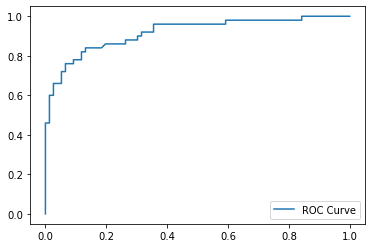

In [28]:
y_pred_proba = model.predict_proba(x_test_tfidf)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label="ROC Curve")
plt.legend(loc=4)
plt.show()

In [29]:
print(auc)

0.9172368421052631


In [29]:
type(y_test)

numpy.ndarray

<h3>Save Model</h3>

In [41]:
import pickle

filename = 'jobmarket_logreg.sav'
pickle.dump(model, open(filename, 'wb'))